# Source Panel Methods

The source panel method is a numerical implementation used to solve for incompressible flows around both non-lifting and lifting surfaces. Unlike CFD or FEA, the computational domain is a discretization of the surface only which is generally referred to as a boundary element method. The following implementation will solve for the inviscid flow field around any NACA 4 digit airfoil. Although corrections for viscous effects can be incorporated into the method, the following implementation can only calculate lifting forces. The flow around a real finite wing is much more complex including a multitude of other forces but panel methods can still be used for preliminary investigation of airfoil geometry with little computational complexity. The modeling assumptions are accurate for low to moderate angles of attack, low speed flows, and small to moderate airfoil thickness.

## Import Packages

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sys
np.set_printoptions(threshold=sys.maxsize)

## Airfoil Geometry Factors

First, we need to create the coordinates of an airfoil that we would like to investigate, including the relevant geometrical factors needed for computation.

- Inputs
    - D1 -- First digit of NACA 4 digit airfoil
    - D2 -- Second digit of NACA 4 digit airfoil
    - D3 -- Third digit of NACA 4 digit airfoil
    - D4 -- Fourth digit of NACA 4 digit airfoil
    - c -- Chord length [m] [ft]
    - alpha -- Angle of attack [deg]
    - nop -- Number of panels for approximation
- Outputs
    - XB -- X-coordinates of boundary points 
    - YB -- Y-coordinates of boundary points
    - XC -- X-coordinates of control points
    - YC -- Y-coordinates of control points
    - theta -- angle of r with respect to the x-axis
    - beta -- angle between normal vector and free stream velocity vector
    - s -- length of panel

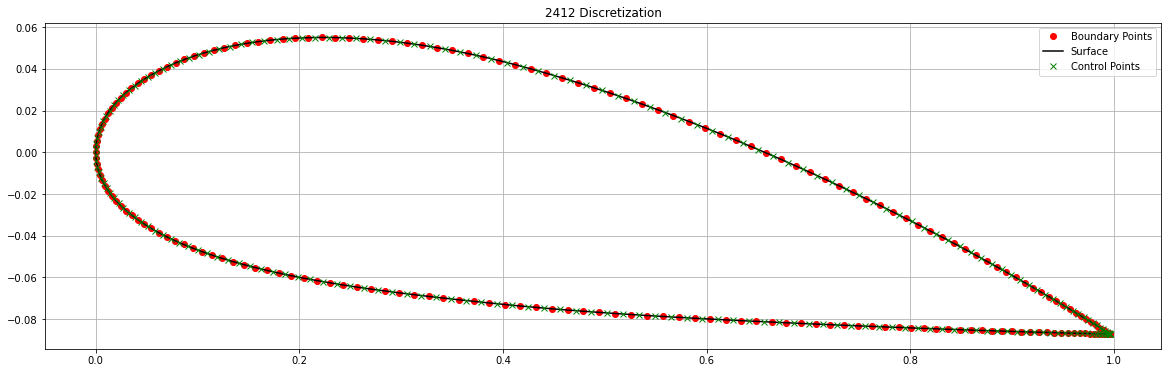

In [176]:
foil = '2412'

D1 = foil[0]
D2 = foil[1]
D3 = foil[2]
D4 = foil[3]
c = 1
alpha = 5
nop = 200

def panel_gen(D1,D2,D3,D4,c,alpha,nop):
    
    alpha = math.radians(alpha)
    
    t = float(D3+D4)/100       # define thickness from symbolic imputs 
    m = float(D1)*0.01                                               # m coefficient
    p = float(D2)*0.1                                                # p coefficient 
    
    # Calculate Camber Line
    x=np.linspace(0,2*np.pi,nop+1);
    x=c*0.5*(np.cos(x)+1);
    
    # populate y_c
    y_c = np.zeros(nop+1)

    for i in range(nop):                                     # loop from 0 to # of data points + 1
        if (0 <= x[i]) and (x[i] <= p*c):                      # piecewise constraint
            y_c[i] = (m*x[i]/p**2)*(2*p - x[i]/c)               # thickness equation
        elif (p*c <= x[i]) and (x[i] <= c):                    # piecewise constraint
            y_c[i] = m*((c-x[i])/(1-p)**2)*(1 + (x[i]/c) - 2*p) # thickness equation
                                                               # end conditional statements                                                                     # end for loop

    y_c[nop] = 0
    x_t = x*np.cos(alpha) + y_c*np.sin(alpha)                  # transform x coordinates for AOA
    y_c_t = -x*np.sin(alpha) + y_c*np.cos(alpha)               # transform y coordinates for AOA  
    
    # Calculate Theta by dyc/dx
    
    # populate dy_c
    dy_c = np.zeros(nop+1)

    for i in range(nop):                                       # loop from 1 to # of data points + 1
        if (0 < x[i]) and (x[i] < p*c):                        # piecewise constraint
            dy_c[i] = (2*m/p**2)*(p-x[i]/c)                    # thickness equation
        elif (p*c < x[i]) and (x[i] < c):                      # piecewise constraint
            dy_c[i] = ((2*m)/((1-p)**2))*(p-x[i]/c)            # thickness equation

    dy_c[nop] = 0;
    theta = np.zeros(len(dy_c))
    for i in range(len(dy_c)):
        theta[i] = math.atan2(dy_c[i],1)        # theta for airfoil coordinates
        
    # Calculate Symmetrical Airfoil Coordinates
    y_t = c*5*t*(0.2969*np.sqrt(x/c) - 0.1260*x/c - 0.3516*(x/c)**2 + 0.2843*(x/c)**3 - (0.1036)*(x/c)**4) # symmetrical airfoil equation
    
    # Calculate Camber Airfoil Coordinates
    XU = (x - y_t*np.sin(theta))                              # x-coordinates for upper surface
    XL = (x + y_t*np.sin(theta))                              # x-coordinates for lower surface
    YU = (y_c + y_t*np.cos(theta))                            # y-coordinates for upper surface
    YL = (y_c - y_t*np.cos(theta))                            # y-coordinates for lower surface

    # Transform Coordinates   

    XU_t = XU*np.cos(alpha) + YU*np.sin(alpha)                    # transform XU to represent AOA                 
    XL_t = XL*np.cos(alpha) + YL*np.sin(alpha)                    # transform XL to represent AOA
    YU_t = -XU*np.sin(alpha) + YU*np.cos(alpha)                   # transform YU to represent AOA
    YL_t = -XL*np.sin(alpha) + YL*np.cos(alpha)                   # transform YL to represent AOA

    XU_t = XU_t[0:int(nop/2)]                                    # eliminate symmetry of coordinates
    XL_t = XL_t[0:int(nop/2)]                                    # eliminate symmetry of coordinates
    YU_t = YU_t[0:int(nop/2)]                                    # eliminate symmetry of coordinates
    YL_t = YL_t[0:int(nop/2)]                                    # eliminate symmetry of coordinates
    
    # Combine Vectors to Find Boundary Points

    XB = np.zeros(nop+1)                                      # populate x boundary point matrix
    XB[0:int(nop/2)] = (XL_t)                                 # replace first half of XB matrix with lower surface coordinates
    XB[int(nop/2)] = 0                                        # define origin
    XB[int(nop/2)+1:int(nop)+1] = np.flip(XU_t,axis=0)        # replace second half of XB matrix with upper surface coordinates
  
    YB = np.zeros(nop+1)                                      # populate y boundary point matrix
    YB[0:int(nop/2)] = (YL_t)                                 # replace first half of YB matrix with lower surface coordinates
    YB[int(nop/2)] = 0                                        # define origin
    YB[int(nop/2)+1:int(nop)+1] = np.flip(YU_t,axis=0)        # replace second half of YB matrix with upper surface coordinates
    
    # Control Points
    XC = np.zeros(len(XB))
    YC = np.zeros(len(YB))
    for i in range(nop):                                       # loop from 1 to # of panels
        XC[i] = 0.5*(XB[i] + XB[i+1]);                         # x coordinate of control point
        YC[i] = 0.5*(YB[i] + YB[i+1]);                         # y coordinate of control point

    # Panel Geometry
    s = np.zeros(nop)
    thet = np.zeros(nop)
    for i in range(nop):                                                # loop from 1 to # of panels
        s[i] = np.sqrt((XB[i+1] - XB[i])**2 + (YB[i+1] - YB[i])**2);    # distance from boundary point to cotrol point  
        thet[i] = math.atan2((YB[i+1] - YB[i]),(XB[i+1] - XB[i]));      # angle of panel to x axis                            

    theta = thet                                                           
    beta = theta + np.pi/2                                              # angle between normal vector and free stream velocity 
    
    #XB = XB[:nop]
    #YB = YB[:nop]
    XC = XC[:nop]
    YC = YC[:nop]
        
    # Plot
    plt.figure(figsize=(20,6))
    plt.title(D1+D2+D3+D4+' Discretization')
    plt.plot(XB,YB,'ro')
    plt.plot(XB,YB,'k')
    plt.plot(XC,YC,'xg')
    plt.legend(['Boundary Points','Surface','Control Points'])
    plt.grid()
    plt.show()
    
    return XB,YB,XC,YC,theta,beta,s

XB,YB,XC,YC,theta,beta,s = panel_gen(D1,D2,D3,D4,c,alpha,nop)

## Compute Vortex Strengths

Now we can solve a system of linear equations for the vortex strengths at each of the control points

- Inputs 
    - XB -- X Boundary Points
    - YB -- Y Boundary Points
    - XC -- X Control Points
    - YC -- Y Control Points
    - theta -- Angle of r with respect to the x-axis
    - nop -- Number of panels
    - s -- Length of panel 
- Outputs 
    - gamma -- Vortex strength
    - at -- Tangential component of vortex strength

In [177]:
def vortex_strength(XB,YB,XC,YC,theta,nop,s):
    
    # Calculate Coefficients

    an = np.zeros([nop+1,nop+1])                                                       # populate an matrix
    at = np.zeros([nop+1,nop+1])                                                       # populate at matrix

    cn1 = np.zeros([nop,nop])
    cn2 = np.zeros([nop,nop])
    ct1 = np.zeros([nop,nop])
    ct2 = np.zeros([nop,nop])
    
    for i in range(nop):                                                                # loop from 1 to number of ith panels
        for j in range(nop):                                                            # loop from 1 to number of jth panels
            if i == j:                                                                  # if i = j, return magnitude of vortex source influence coeff.
                cn1[i,j] = -1                                                           # normal coefficient 1
                cn2[i,j] = 1                                                            # normal coefficient 2
                ct1[i,j] = np.pi/2                                                      # tangential coefficient 1
                ct2[i,j] = np.pi/2                                                      # tangential coefficient 2
            else:
                A = -(XC[i] - XB[j])*np.cos(theta[j]) - (YC[i] - YB[j])*np.sin(theta[j])   # A coefficient
                B = (XC[i] - XB[j])**2 + (YC[i] - YB[j])**2                                # B coefficient
                C = np.sin(theta[i] - theta[j])                                            # C coefficient
                D = np.cos(theta[i] - theta[j])                                            # D coefficient
                E = (XC[i] - XB[j])*np.sin(theta[j]) - (YC[i] - YB[j])*np.cos(theta[j])    # E coefficient
                F = np.log(1 + (s[j]**2 + 2*A*s[j])/B)                                     # F coefficient
                G = math.atan2((E*s[j]),(B+A*s[j]))                                        # G coefficient
                P = (XC[i] - XB[j])*np.sin(theta[i] - 2*theta[j]) + (YC[i] - YB[j])*np.cos(theta[i] - 2*theta[j]) # P coefficient
                Q = (XC[i] - XB[j])*np.cos(theta[i] - 2*theta[j]) - (YC[i] - YB[j])*np.sin(theta[i] - 2*theta[j]) # Q coefficient
                cn2[i,j] = D + 0.5*Q*F/s[j] - (A*C+D*E)*G/s[j]                             # normal coefficient 1
                cn1[i,j] = 0.5*D*F + C*G - cn2[i,j]                                        # normal coefficient 2
                ct2[i,j] = C + 0.5*P*F/s[j] + (A*D - C*E)*G/s[j]                           # tangential coefficient 1
                ct1[i,j] = 0.5*C*F - D*G - ct2[i,j]                                        # tangential coefficient 2

    # Solve for Vortex Strength Gamma 
    
    for i in range(nop):                                                                   # loop from 1 to number of panels
        an[i,0] = cn1[i,0]
        an[i,-1] = cn2[i,int(nop-1)]
        at[i,0] = ct1[i,0]
        at[i,-1] = ct2[i,int(nop-1)]
        for j in range(1,nop):
            an[i,j] = cn1[i,j] + cn2[i,[j - 1]]
            at[i,j] = ct1[i,j] + ct2[i,[j - 1]]
            
    
    #an = np.delete(an, 0, 1)
    rhs = np.sin(theta)                                                           # Right hand side of equation

    # Kutta Condition
    an[-1,0] = 1
    an[-1,-1] = 1
    #rhs[nop+1] = 0
    rhs = np.append(rhs,0)

    for j in range(1,nop):
        an[-1,j]=0
        
    rhs = rhs[:]                                                           
    # Solve Linear System for Vortex Strength, Gamma
    
    gamma = np.linalg.solve(an, rhs)
    at = at
    
    return gamma,at

gamma,at = vortex_strength(XB,YB,XC,YC,theta,nop,s)

# Compute Coefficients

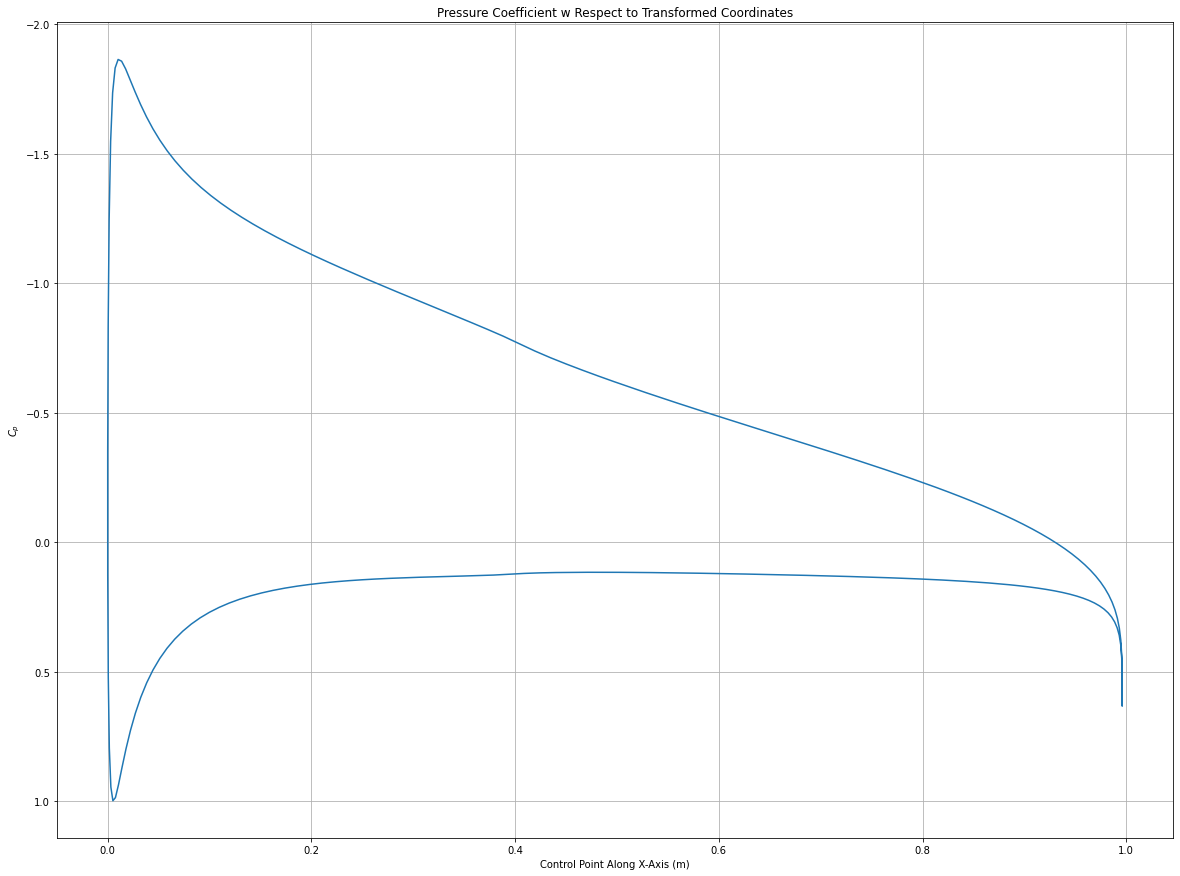

In [193]:
# Velocity and Pressure Coefficients

v = np.zeros(nop)
cp = np.zeros(nop)

for i in range(nop):
    smt = 0
    for j in range(nop+1):
        smt+=at[i,j]*gamma[j]
        
    v[i]=(np.cos(theta[i])+smt)                                               # v is the velocity parallel to the panel at the control points
    cp[i]=1-(v[i])**2                                                         # cp is the pressure coeff at the control points

# plot the pressure coefficient at the control points
plt.figure(figsize=(20,15))
plt.title('Pressure Coefficient w Respect to Transformed Coordinates')
plt.plot(XC,cp)
plt.xlabel('Control Point Along X-Axis (m)')
plt.ylabel('$C_p$')
plt.grid()
plt.gca().invert_yaxis()

# compute normal and axial force coefficients
CN = -cp*s*np.sin(beta)                                                     # Normal force coeff
CA = -cp*s*np.cos(beta)                                                     # Axial force coeff

# lift coefficient
CL = CN*np.cos(alpha) - CA*np.sin(alpha)
CL = np.sum(CL)